<a href="https://colab.research.google.com/github/katekolarikova/Box2DCarRacing_ReinforcementLearning/blob/main/RF_project_box2D_car_racing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BOX2D - Car Racing project (Reinforcement Learning)

The goal of this project is to create and train Reinforcement learning agent. The agent was trained in the Box2D CarRacing environment from OpenAI Gym, which simulates a racing track with a car. The car's objective is to follow the road while avoiding stepping on the grass. The agent's task is to learn how to drive by predicting the optimal future actions based on the current position of the car and the track layout.

The most importnat information regarding to the enviroment are in table below.

|  Item | Value |
|:--------:|:--------:|
| Action Space |  Box([-1. 0. 0.], 1.0, (3,), float32) |  
| Observation Shape  | Box(0, 255, (96, 96, 3), uint8) |


* action space - set of all possible actions the agent can take. In this example it its three dimensional action space (steering, gas, breaking).
* observation shape - the observation of current state in a enviroment which agent could get. In this case picture in size 96x96 pixels.

In the following cells, the agent will be implemented and trained. Also the hyperparameters will be tuned to achive better results.



## Import

Firstly all neccessary libraries are installed and imported.

In [ ]:
!pip install swig
!pip install stable-baselines3[extra] # this will install also gymnasium
!pip install gymnasium[accept-rom-license,box2d]
!pip install Cmake
!pip install nes-py
!pip install wheel
!pip install pyvirtualdisplay
!sudo apt-get install -y xvfb ffmpeg
!sudo apt-get install xvfb
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.6 MB/s eta 0:00:00
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446661 sha256=127e221460d5deb75bb0381c56946618b06a8c3b71decefa906f5408edad6a47
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built Auto

In [ ]:
import gym
from gym import spaces
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
import numpy as np
from gym import ActionWrapper
import random
from collections import deque
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import argparse
from collections import deque
import cv2
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D, Input, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from stable_baselines3 import DQN
from gym import ActionWrapper

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:51: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


# Enviroment example

The output of the following cell illustrates the entire scenario and provides a method for displaying the game within a Jupyter Notebook. In this case, the car is not controlled by an agent, and each subsequent action is chosen at random.

In [ ]:
# Creating a virtual display
display = Display(visible=0, size=(1400, 900))
display.start()

# Create the CarRacing environment
env = gym.make("CarRacing-v2")

env.metadata['render_fps'] = 30 # frame rate of enviroments
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Reward Range: {env.reward_range}")

# Reset the environment to the start
env.reset()

# Setup the wrapper to record the video
video_callable = lambda episode_id: True # enable video recording for every episode
env = RecordVideo(env, video_folder='./videos')

# Run the environment until done
done = False
total_reward = 0

while not done:
      action = env.action_space.sample()  # Take a random action
      obs, reward, done, info = env.step(action)  # Step in the environment
      total_reward += reward

print(f"Total Reward: {total_reward}")
env.close()

# Display the recorded video in the notebook
video_path = glob.glob('videos/*.mp4')[0]
video = io.open(video_path, 'r+b').read()
encoded = base64.b64encode(video)

# Display the video inside the notebook
ipythondisplay.display(HTML(data='''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
    </video>
'''.format(encoded.decode('ascii'))))


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with

Action Space: Box([-1.  0.  0.], 1.0, (3,), float32)
Observation Space: Box(0, 255, (96, 96, 3), uint8)
Reward Range: (-inf, inf)


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Total Reward: -22.779922779922966


## Classes
 The following code cells implementes three different classes:

*   Experience memory
*   DQN
*   CarRacingDQNAgent

They represent the main concepts used in DeepQ RL. Experience memory is used for storing the experiences agent can learn from. Experience is usually defined as an tuple: (state, action, reward, next state).

According to these experiences, the agent tries to improve his Deep Q networks. This network is responsible for chosing a next move in a game enviroment.



#### Experience Memory

This class represents the exprerience memory. It allows us to push new items, when capacity allows to. If the memory is already full, the oldest item is removed and then new item is added.

In [ ]:
class ExperiecneMemory:
  def __init__(self, max_size):
    self.max_size = max_size
    self.memory = []

  def push(self, item):
    if len(self.memory) > self.max_size:
      self.memory.pop(0)
    self.memory.append(item)


  def sample(self, batch_size):
      if len(self.memory) > batch_size:
          return random.sample(self.memory, batch_size)
      else:
          return self.memory

  def __len__(self):
    return len(self.memory)

#### Deep Q - Network

Deep Q network combines the principles of neural networks together with Q learning. The main idea is that the agent uses two neural networks with the same structure: a primary model for prediction and a target model, which is updated less frequently to stabilize learning and prevent sudden changes in performance and smoothing the learning process. Both of the networks are then considere during learning process.

The following cell describe the structure of the network.

In [ ]:
class DQN:
    def __init__(self, action_space):
        self.action_space = action_space

    def build(self, input_shape,  learning_rate):

        inputs = Input(shape=input_shape)

        initializer = tf.keras.initializers.glorot_normal(seed=0)

        x = Conv2D(filters=6, kernel_size=(7, 7), strides=3, activation='relu')(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)

        x = Conv2D(filters=12, kernel_size=(4, 4), activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)

        x = Conv2D(filters=12, kernel_size=(4, 4), activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2,2))(x)

        x =  Flatten()(x)

        x = Dense(216, activation='relu', kernel_initializer=initializer)(x)
        output = Dense( len(self.action_space), activation="softmax", kernel_initializer=initializer)(x)

        model = Model(inputs=inputs, outputs=output)
        # model.summary()

        self.compile(model, learning_rate)

        return model

    def compile(self, model, learning_rate):
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate, epsilon=1e-7))

#### Agent

The following code section represents a class defining our reinforcement learning agent, which will predict the next move of the car.


The agent’s two primary components are the experience memory
and the deep Q-network (DQN). The
main way the agent was implemented is by leveraging these two
components, allowing it to exploit and explore the environment
while using experience memory to update the DQN model. Interestingly, the agent uses two neural networks with the same structure: a
primary model for prediction and a target model, which is updated
less frequently to stabilize learning and prevent sudden changes in
performance and smoothing the learning process. The agent also
employs the epsilon-greedy strategy, a core RL algorithm, where
epsilon is a threshold and controls the balance between exploration
and exploitation. In addition to image input, the agent uses a frame stack
to capture movement direction, which provides richer contextual
information.

One of iprovements in this solution is reducing continuos action space to the discrete action space. Continuous control requires precise actions, making it challenging for the agent to effectively explore the environment due to the large number of potential moves. By reducing the action space to a discrete set of actions, the agent can explore more efficiently, train faster, and focus on more relevant behaviors. It is crucial to select the discrete actions carefully. One useful approach is to divide them into "hard" and "soft" actions (more details at: https://notanymike.github.io/Solving-CarRacing/). In hard actions, one of the parameters dominates while the others are set to zero, whereas soft actions combine lower values of all three parameters, allowing more nuanced control in all directions.

In [ ]:
class CarRacingDQNAgent:
    def __init__(
        self,
        action_space    = [
            # (Steering Wheel, Gas, Break)

            # basic discrete action
            (-1.0, 0.0, 0.0), # turn left
            (1.0, 0.0, 0.0), # turn right
            (0.0 , 0.0, 0.8), #brake
            (0.0, 1.0,  0.0), # accelerate
            (0.0, 0.0,0.0), # do nothing

            # soft discrete action
            (-0.5 , 0.5 , 0.0), # Turn_left_soft_&_Accelerate_soft
            (0.5 , 0.5 , 0.0), # Turn_right_soft_&_Accelerate_soft
            (-0.5 , 0.0 , 0.2), # Turn_left_soft_&_brake_soft
            (0.5 , 0.0 , 0.2), # Turn_right_soft_&_brake_soft

            # soft and hard
            (-1.0 , 0.5 , 0.0), # Turn_left_hard_&_Accelerate_soft
            (1 , 0.5 , 0.0), # Turn_right_hard_&_Accelerate_soft
            (-1.0 , 0.0 , 0.2), # Turn_left_hard_&_brake_soft
            (1.0 , 0.0 , 0.2), # Turn_right_hard_&_brake_soft

            (-0.5 , 1.0 , 0.0), # Turn_left_soft_&_Accelerate_hard
            (0.5 , 1.0 , 0.0), # Turn_right_soft_&_Accelerate_hard
            (-0.5 , 0.0 , 0.8), # Turn_left_soft_&_brake_hard
            (0.5 , 0.0 , 0.8), # Turn_right_soft_&_brake_hard


            # hard discrete actions
            (-1.0 , 1.0 , 0.0), # Turn_left_hard_&_Accelerate_hard
            (1.0 , 1.0 , 0.0), # Turn_right_hard_&_Accelerate_hard
            (-1.0 , 0.0 , 0.8), # Turn_left_hard_&_brake_hard
            (1.0 , 0.0 , 0.8), # Turn_right_hard_&_brake_hard
        ],
        frame_stack_num = 3,
        memory_size     = 5000,
        gamma           = 0.95,  # discount rate
        epsilon         = 1.0,   # exploration rate
        epsilon_min     = 0.1,
        epsilon_decay   = 0.9999,
        learning_rate   = 0.001
    ):
        self.action_space    = action_space
        self.frame_stack_num = frame_stack_num
        self.memory          = ExperiecneMemory(memory_size) # if it exeeded the space, the oldest element will be removed when adding a new one
        self.gamma           = gamma
        self.epsilon         = epsilon # the probability of choosing a random action
        self.epsilon_min     = epsilon_min
        self.epsilon_decay   = epsilon_decay
        self.learning_rate   = learning_rate
        self.model           = self.build_model()
        self.target_model    = self.build_model()
        self.loss_history    = []
        self.epsilon_history = [epsilon]
        self.update_target_model()

    def build_model(self):
        model = DQN(self.action_space)
        return model.build((96, 96, self.frame_stack_num), self.learning_rate)

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # experience memory
    def memorize(self, state, action, reward, next_state, done):
        self.memory.push((state, self.action_space.index(action), reward, next_state, done))

    def act(self, state): # choose action to perform
        if np.random.rand() > self.epsilon:# explotation
            act_values = self.model.predict(np.expand_dims(state, axis=0))
            action_index = np.argmax(act_values[0])
        else: # exploration
            action_index = random.randrange(len(self.action_space))
        return self.action_space[action_index]

    def replay(self, batch_size):  # use past experiences to train the network
        print("replay")

        minibatch = self.memory.sample(batch_size)


        input_state = [] # states - the values network gets at the input
        train_target_Q_values = [] # the Q values used to update the network


        for state, action_index, reward, next_state, done in minibatch:

            # Get predicted Q value for each action
            predicted_Q_value = self.model.predict(np.expand_dims(state, axis=0))[0] # prediction made by policy network

            # Compute target Q value
            if done:
                predicted_Q_value[action_index] = reward # episode is done, not future action
            else:
                next_state_q_value = self.target_model.predict(np.expand_dims(next_state, axis=0))[0] # Q value of the next state
                target_Q_value = reward + self.gamma * np.amax(next_state_q_value) # for taken action
            predicted_Q_value[action_index] = target_Q_value # update the q value for taken action, leave other unchanged
            input_state.append(state)
            train_target_Q_values.append(predicted_Q_value)

        # look at the initial state, update the network acording to the target Q values ( it tries to minimize the loss function between the one provided as input and target  one, takes care of backpropagation the computed information)
        history = self.model.fit(np.array(input_state), np.array(train_target_Q_values), epochs=1, verbose=0)

        # store loss function values during training
        loss = history.history['loss']
        self.loss_history.append(loss)

        # apply greedy strategy
        self.epsilon_greedy_strategy()

    def epsilon_greedy_strategy(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            self.epsilon_history.append(self.epsilon)
        else:
            self.epsilon = self.epsilon_min
            self.epsilon_history.append(self.epsilon)

    def load(self, name):
        self.model.load_weights(name)
        self.update_target_model()

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()

    def plot_epsilon(self):
        plt.plot(self.epsilon_history)
        plt.xlabel('Epoch')
        plt.ylabel('Epsilon')
        plt.show()

    def save(self, name):
        self.target_model.save_weights(name)

## Training

#### Training a model

To prepare an training proccess is important to understand how the whole Q learning works. The main purpose during the training is to train the network called policy network. This network will be later used to predict the next movements in real enviroment. The overview of the training process is listed below. The whole process is divided into episodes. Episode represents some small fraction of the game which is solved together. At the beggining of the episode, the game is put into initial state that the network can start learning from the beggining of the game again. Gennerally, the input for the network is extracted, than according to this input the agent will predict next move and create an experience. Than, if we have enough experiences, the agent can try to learn from them. At the end of the episode is important to check if targer network should be updated or not. After finishing the whole training process the graph displaying the gained rewards is created.


At the beggining of each episode
1. reset the enviroment to the initial state
2. preprocess the initil state

In each episode:
1. reset the game to the beggining
2. preprocess the input
3. create a batch of images of the state the network will use
4. let agent to choose the action according to the the game state
5. compute the reward
6. add experience to the agent memory
7. prepare game for the next state
8. learn from previous experiences if possible

After finishing the episode
1. update target network if possible

In [ ]:
# convert image to grey scale
def image_preprocesing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image/ 255.0
    return image

def queue_position_converter(deque):
    frame_stack = np.array(deque)
    #(frames, x, y) -> (x, y, frames)
    return np.transpose(frame_stack, (1, 2, 0))

def train_the_agent_network(agent, env, SKIP_FRAMES = 2, number_of_episodes = 8, replay_batch_size = 64, period_to_update_target_model = 5, model_name = './test.weights.h5'):

  rewards_history = []
  SAVE_TRAINING_FREQUENCY = 2
  # running the code for given number of episodes
  for episode in range(number_of_episodes):
      # go to the init state at the beggining of each episode
      init_state = env.reset()

      #preproces the image - resize and convert to RGB
      init_state = image_preprocesing(init_state)

      expected_return = 0
      negative_reward_counter = 0

      # create a queue where we can store frames which should be processed by NN
      # it has a size of how many frimes will be proccesed at one time
      state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)
      done = False

      # episode main loop
      while True:

          # preprocess current frame
          current_state_frame_stack = queue_position_converter(state_frame_stack_queue)

          # agent will choose next action
          action = agent.act(current_state_frame_stack)

          reward = 0
          for _ in range(SKIP_FRAMES+1):
            next_state, r, done, info = env.step(action)
            reward += r
            if done:
                break

          # check wheather the episode is not getting too bad
          negative_reward_counter = negative_reward_counter + 1 if reward < 0 else 0

          # add gained reward to the total reward
          expected_return += reward

            # add new frame to the queue - ready for the next iteration
          next_state = image_preprocesing(next_state)
          state_frame_stack_queue.append(next_state)
          next_state_frame_stack = queue_position_converter(state_frame_stack_queue)

          # create experience memory
          agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)

          # end the episode when it is over or when it just not going anywhere
          if done or negative_reward_counter >= 10 or  expected_return < 0 :
              print('Episode: {}, Total Rewards(adjusted): {:.2}'.format(episode, float(expected_return)))
              break

          # check if we have enough experiences in a memory to learn
          if len(agent.memory) > replay_batch_size:
              agent.replay(replay_batch_size)



      rewards_history.append(expected_return)

      # target model needs to be updated after certain time
      if episode % period_to_update_target_model == 0:
          agent.update_target_model()

      if episode % SAVE_TRAINING_FREQUENCY == 0:
            agent.save('./{}_{}.weights.h5'.format(model_name, episode))

  return rewards_history





## Hyperparameter tunning

The quality of the network and agents depends on the parameters we choose. Therefore, it is necessary to focus on the process of tuning these parameters and finding the best combination. To achieve this, the library called Optuna was used. This library accepts a range of parameters and tries different combinations to find the optimal one. The process of finding the best combination is complex in the background of Optuna, meaning that the library itself is able to evaluate which part of the range is better to use based on previous results.

In this project, we tuned parameters specific to the reinforcement learning agent, as well as the learning rate, which is crucial for the neural network's learning process. The chosen values were:


* gamma: from 0.92 to 0.97
* epsilon_decay: from 0.999 to 0.9999
* learning_rate: from  0.001 to 0.0011

The range for the values was chosen according to the general assumption that learning rate should be low number to make the process well optimized and so on.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


#### Shared parameters

In [ ]:
action_space  = [
            # (Steering Wheel, Gas, Break)

            # basic discrete action
            (-1.0, 0.0, 0.0), # turn left
            (1.0, 0.0, 0.0), # turn right
            (0.0 , 0.0, 0.8), #brake
            (0.0, 1.0,  0.0), # accelerate
            (0.0, 0.0,0.0), # do nothing

            # soft discrete action
            (-0.5 , 0.5 , 0.0), # Turn_left_soft_&_Accelerate_soft
            (0.5 , 0.5 , 0.0), # Turn_right_soft_&_Accelerate_soft
            (-0.5 , 0.0 , 0.2), # Turn_left_soft_&_brake_soft
            (0.5 , 0.0 , 0.2), # Turn_right_soft_&_brake_soft

            # soft and hard
            (-1.0 , 0.5 , 0.0), # Turn_left_hard_&_Accelerate_soft
            (1 , 0.5 , 0.0), # Turn_right_hard_&_Accelerate_soft
            (-1.0 , 0.0 , 0.2), # Turn_left_hard_&_brake_soft
            (1.0 , 0.0 , 0.2), # Turn_right_hard_&_brake_soft

            (-0.5 , 1.0 , 0.0), # Turn_left_soft_&_Accelerate_hard
            (0.5 , 1.0 , 0.0), # Turn_right_soft_&_Accelerate_hard
            (-0.5 , 0.0 , 0.8), # Turn_left_soft_&_brake_hard
            (0.5 , 0.0 , 0.8), # Turn_right_soft_&_brake_hard


            # hard discrete actions
            (-1.0 , 1.0 , 0.0), # Turn_left_hard_&_Accelerate_hard
            (1.0 , 1.0 , 0.0), # Turn_right_hard_&_Accelerate_hard
            (-1.0 , 0.0 , 0.8), # Turn_left_hard_&_brake_hard
            (1.0 , 0.0 , 0.8) ] # Turn_right_hard_&_brake_hard


frame_stack_num = 3

#### Evaluating method

The library needs a method to compare how effective the parameters and training were. For our purposes, we will let the agent play multiple episodes and calculate the average reward. A higher average reward represents better parameters.



In [ ]:
def evaluate_agent(agent, env, episodes=5):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            state = next_state
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

#### Running the optuna tunning

Now, it is possible to run the Optuna training process. The parameter n_trials determines how many different configurations the library will try. In our case, how many different agents will be trained. In this situation, 10 different agents were trained.

In [ ]:
import optuna

def objective(trial):
    gamma = trial.suggest_float('gamma', 0.92, 0.97)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.999, 0.9999)
    lr =  trial.suggest_float('learning_rate', 0.001, 0.0011)


    # initialize and train the agent
    agent = CarRacingDQNAgent(
        gamma=gamma,
        epsilon_decay=epsilon_decay,
        learning_rate=lr
    )

    train_the_agent_network(agent,env, number_of_episodes=7)
    avg_reward = evaluate_agent(agent, env)

    return avg_reward  # value to maximize

# create and optimize the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# best hyperparameters
print(study.best_trial.params)

[I 2024-10-04 22:15:02,297] A new study created in memory with name: no-name-0d899bcf-cc5d-4322-a088-999d7090c2e4
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 26ms/step
Episode: 4, Total Rewards(adjusted): 4.7
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 30ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==================

[I 2024-10-04 22:27:22,244] Trial 0 finished with value: -39.9669451761401 and parameters: {'gamma': 0.9573383107685371, 'epsilon_decay': 0.9995774266250848, 'learning_rate': 0.0010861525851611968}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
Episode: 5, Total Rewards(adjusted): 1.3e+01
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 26ms/step


[I 2024-10-04 22:51:29,459] Trial 1 finished with value: -65.75883073554692 and parameters: {'gamma': 0.9397911092471611, 'epsilon_decay': 0.9990574229409446, 'learning_rate': 0.0010336197266453842}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 29ms/step
Episode: 5, Total Rewards(adjusted): 1.6e+01
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============

[I 2024-10-04 23:12:02,617] Trial 2 finished with value: -51.39834134611097 and parameters: {'gamma': 0.9664546185745615, 'epsilon_decay': 0.9996001626252384, 'learning_rate': 0.0010276757421377838}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 22ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 30ms/step
replay
1/1 [==============================] - 0s 26ms/step
Episode: 5, Total Rewards(adjusted): 7.0
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==================

[I 2024-10-04 23:25:40,001] Trial 3 finished with value: -51.899056237225615 and parameters: {'gamma': 0.9535263236184721, 'epsilon_decay': 0.999511243855757, 'learning_rate': 0.0010544188889802053}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 30ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 26ms/step
Episode: 5, Total Rewards(adjusted): 3.6
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==================

[I 2024-10-04 23:40:30,032] Trial 4 finished with value: -41.044956541526 and parameters: {'gamma': 0.9576200280131951, 'epsilon_decay': 0.9995498759467017, 'learning_rate': 0.0010986055545843755}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 27ms/step


[I 2024-10-05 00:02:24,530] Trial 5 finished with value: -52.374765392046996 and parameters: {'gamma': 0.9670621245174383, 'epsilon_decay': 0.9994192603205362, 'learning_rate': 0.001064059917795084}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 30ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
Episode: 4, Total Rewards(adjusted): 5.5
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==================

[I 2024-10-05 00:10:29,613] Trial 6 finished with value: -47.639999799602094 and parameters: {'gamma': 0.9683054162583808, 'epsilon_decay': 0.9998682982978373, 'learning_rate': 0.0010766570854070891}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 30ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
Episode: 4, Total Rewards(adjusted): 5.2
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 31ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==================

[I 2024-10-05 00:24:08,582] Trial 7 finished with value: -49.405969521870205 and parameters: {'gamma': 0.9384683911762599, 'epsilon_decay': 0.9997728682254622, 'learning_rate': 0.0010600925313419523}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [

[I 2024-10-05 00:48:29,499] Trial 8 finished with value: -45.02718064326937 and parameters: {'gamma': 0.9522318887126091, 'epsilon_decay': 0.9995633059201695, 'learning_rate': 0.0010530486916626165}. Best is trial 0 with value: -39.9669451761401.


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 30ms/step
replay
1/1 [

[I 2024-10-05 01:02:29,168] Trial 9 finished with value: -33.71642400523307 and parameters: {'gamma': 0.9374774643934558, 'epsilon_decay': 0.9994114900500196, 'learning_rate': 0.00106300377957255}. Best is trial 9 with value: -33.71642400523307.


{'gamma': 0.9374774643934558, 'epsilon_decay': 0.9994114900500196, 'learning_rate': 0.00106300377957255}


#### Result of Tunning

As the output of the tuning process, we obtained the optimal parameters and the total reward.

Best is trial 9 with value: -33.71642400523307.
{'gamma': 0.9374774643934558, 'epsilon_decay': 0.9994114900500196, 'learning_rate': 0.00106300377957255'}

## Test the best agent - play a game

After tuning, we can let our agent play multiple games at different stages of the training process. The maximum number of episodes we will use for training is 50, and the evaluation steps will be at 10, 30, and 50 episodes. After each stage of the training process, we will let our agent play a game. For both the training and the game, we will also generate a graphs representing the loss function and the rewards gained.

A challenge encountered during training was the computational
intensity. Training the network, even for a small number of episodes,
demands significant computational resources and accumulates into
hours of runtime. This constraint also influenced the design of the hyperparameter tuning, as we focused on a smaller range of parameters
to balance computational costs with effective exploration of the
parameter space.

In [ ]:
def plot_rewards(rewards_history):
    plt.plot(rewards_history)
    plt.xlabel('Epoch')
    plt.ylabel('Reward')
    plt.show()

In [ ]:
def playGame(agent, env, model_name='./test.weights.h5', play_episodes = 10):
  #agent.load(model_name)
  display = Display(visible=0, size=(1400, 900))
  display.start()

  env.metadata['render_fps'] = 30 # frame rate of enviroments

  # Reset the environment to the start
  obs = env.reset()

  # Setup the wrapper to record the video
  video_callable = lambda episode_id: True # enable video recording for every episode
  env = RecordVideo(env, video_folder='./videos', episode_trigger=video_callable)

  # Run the environment until done
  done = False
  total_reward = 0
  rewards_history =[]

  for e in range(play_episodes):
          init_state = env.reset()
          init_state = image_preprocesing(init_state)

          total_reward = 0
          punishment_counter = 0
          state_frame_stack_queue = deque([init_state]*agent.frame_stack_num, maxlen=agent.frame_stack_num)

          while True:
              env.render()

              current_state_frame_stack = queue_position_converter(state_frame_stack_queue)
              action = agent.act(current_state_frame_stack)
              next_state, reward, done, info = env.step(action)

              total_reward += reward

              next_state = image_preprocesing(next_state)
              state_frame_stack_queue.append(next_state)

              if done:
                  print('Episode: {}/{}, Total Rewards: {:.2}'.format(e+1, play_episodes, float(total_reward)))
                  rewards_history.append(total_reward)
                  break

  print(f"Total Reward: {total_reward}")
  env.close()

  # Display the recorded video in the notebook
  video_path = glob.glob('videos/*.mp4')[0]
  video = io.open(video_path, 'r+b').read()
  encoded = base64.b64encode(video)

  # Display the video inside the notebook
  ipythondisplay.display(HTML(data='''
      <video width="640" height="480" controls>
          <source src="data:video/mp4;base64,{0}" type="video/mp4" />
      </video>
  '''.format(encoded.decode('ascii'))))

  return rewards_history


#### Training period - 10 episodes

In [ ]:
action_space  = [
            # (Steering Wheel, Gas, Break)

            # basic discrete action
            (-1.0, 0.0, 0.0), # turn left
            (1.0, 0.0, 0.0), # turn right
            (0.0 , 0.0, 0.8), #brake
            (0.0, 1.0,  0.0), # accelerate
            (0.0, 0.0,0.0), # do nothing

            # soft discrete action
            (-0.5 , 0.5 , 0.0), # Turn_left_soft_&_Accelerate_soft
            (0.5 , 0.5 , 0.0), # Turn_right_soft_&_Accelerate_soft
            (-0.5 , 0.0 , 0.2), # Turn_left_soft_&_brake_soft
            (0.5 , 0.0 , 0.2), # Turn_right_soft_&_brake_soft

            # soft and hard
            (-1.0 , 0.5 , 0.0), # Turn_left_hard_&_Accelerate_soft
            (1 , 0.5 , 0.0), # Turn_right_hard_&_Accelerate_soft
            (-1.0 , 0.0 , 0.2), # Turn_left_hard_&_brake_soft
            (1.0 , 0.0 , 0.2), # Turn_right_hard_&_brake_soft

            (-0.5 , 1.0 , 0.0), # Turn_left_soft_&_Accelerate_hard
            (0.5 , 1.0 , 0.0), # Turn_right_soft_&_Accelerate_hard
            (-0.5 , 0.0 , 0.8), # Turn_left_soft_&_brake_hard
            (0.5 , 0.0 , 0.8), # Turn_right_soft_&_brake_hard

            # hard discrete actions
            (-1.0 , 1.0 , 0.0), # Turn_left_hard_&_Accelerate_hard
            (1.0 , 1.0 , 0.0), # Turn_right_hard_&_Accelerate_hard
            (-1.0 , 0.0 , 0.8), # Turn_left_hard_&_brake_hard
            (1.0 , 0.0 , 0.8) ] # Turn_right_hard_&_brake_hard

gamma = 0.9374774643934558
epsilon_decay = 0.9994114900500196
learning_rate = 0.00106300377957255
model_name='model10'
frame_stack_num = 3

In [ ]:
agent10 = CarRacingDQNAgent(action_space = action_space, frame_stack_num = frame_stack_num, gamma=gamma, epsilon_decay=epsilon_decay, learning_rate=learning_rate)
reward_history = train_the_agent_network(agent10,env, number_of_episodes=10, model_name=model_name)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 22ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
Episode: 7, Total Rewards(adjusted): 4.0
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 22ms/step
replay
1/1 [==================

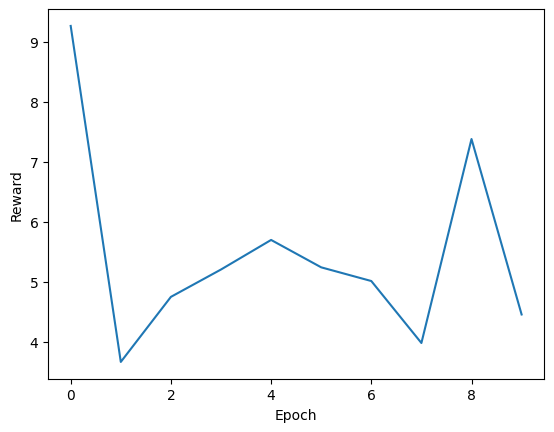

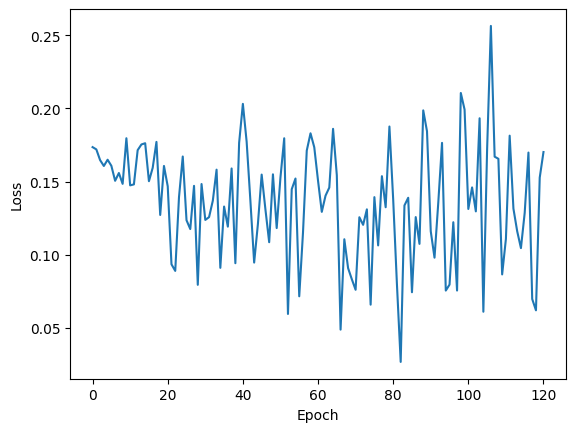

In [ ]:
plot_rewards(reward_history)
agent10.plot_loss()

###### Play a game (trained for 10 episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `ren

1/1 [==============================] - 0s 36ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 23ms/step
Episode: 1/5, Total Rewards: -4.6e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more infor

1/1 [==============================] - 0s 23ms/step
Episode: 2/5, Total Rewards: -2.6e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 24ms/step
Episode: 3/5, Total Rewards: -4.8e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more infor

1/1 [==============================] - 0s 25ms/step
Episode: 4/5, Total Rewards: -5.1e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more infor

1/1 [==============================] - 0s 23ms/step
Episode: 5/5, Total Rewards: -6.1e+01
Total Reward: -60.78431372549072


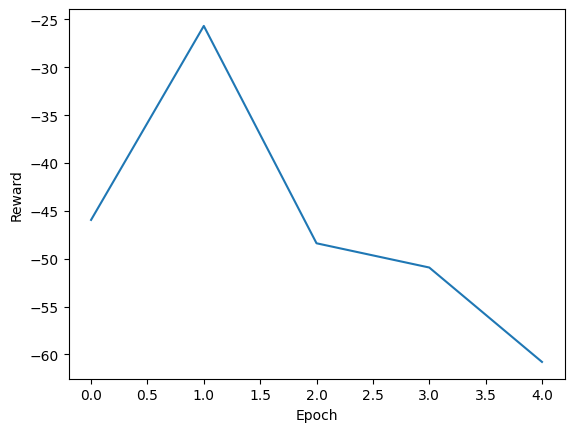

In [ ]:
reward_history = playGame(agent10, env, play_episodes=5, model_name=model_name)
plot_rewards(reward_history)

#### Training peridod - 30 episodes

In [ ]:
model_name = 'model30'
agent30 = CarRacingDQNAgent(action_space = action_space, frame_stack_num = frame_stack_num, gamma=gamma, epsilon_decay=epsilon_decay, learning_rate=learning_rate)
reward_history = train_the_agent_network(agent30,env, number_of_episodes=30, model_name=model_name)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 21ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [

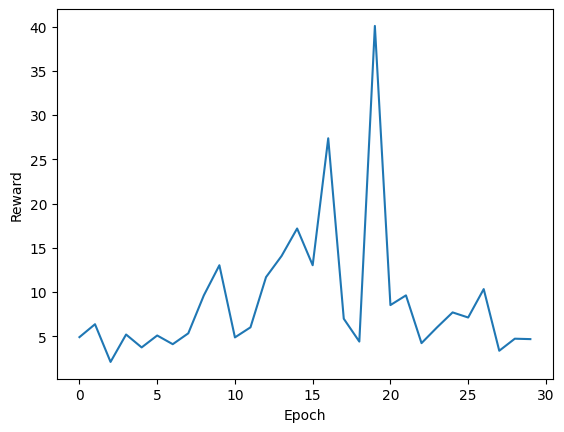

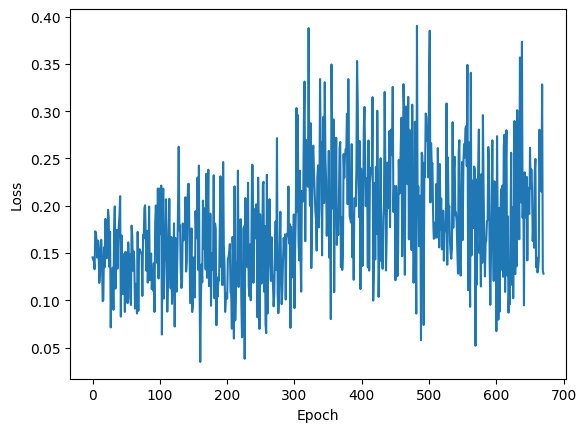

In [ ]:
plot_rewards(reward_history)
agent30.plot_loss()

###### Play a game (trained for 30 episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initializatio

1/1 [==============================] - 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 27ms/step
Episode: 1/5, Total Rewards: -7.1e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


Episode: 2/5, Total Rewards: -8e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 24ms/step
Episode: 3/5, Total Rewards: -6.9e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more infor

1/1 [==============================] - 0s 28ms/step
Episode: 4/5, Total Rewards: -7.2e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


1/1 [==============================] - 0s 43ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 26ms/step
Episode: 5/5, Total Rewards: -7.8e+01
Total Reward: -77.77777777777757


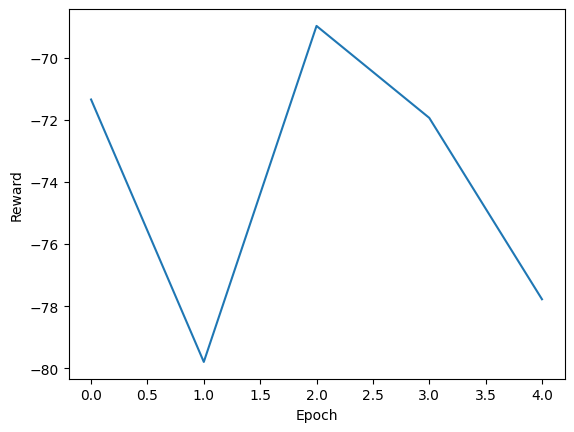

In [ ]:
reward_history = playGame(agent30, env, play_episodes=5, model_name=model_name)
plot_rewards(reward_history)

##### Training period - 50 episodes

In [ ]:
model_name='model50'
agent50 = CarRacingDQNAgent(action_space = action_space, frame_stack_num = frame_stack_num, gamma=gamma, epsilon_decay=epsilon_decay, learning_rate=learning_rate)
reward_history = train_the_agent_network(agent50,env, number_of_episodes=50, model_name=model_name)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 24ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 25ms/step
replay
1/1 [==============================] - 0s 23ms/step
replay
1/1 [==============================] - 0s 29ms/step
replay
1/1 [==============================] - 0s 28ms/step
replay
1/1 [==============================] - 0s 31ms/step
replay
1/1 [==============================] - 0s 26ms/step
Episode: 48, Total Rewards(adjusted): 2.2e+01
1/1 [==============================] - 0s 27ms/step
replay
1/1 [==============================] - 0s 26ms/step
replay
1/1 [====================

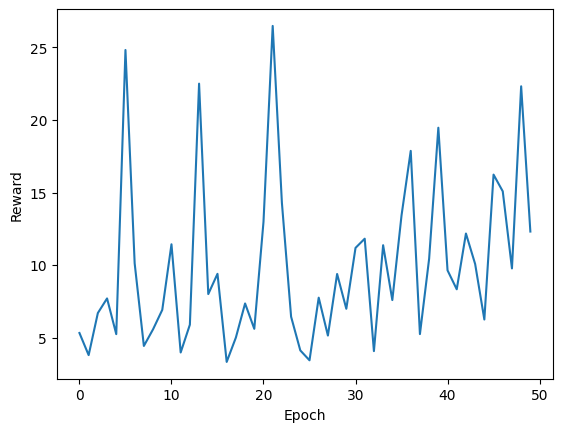

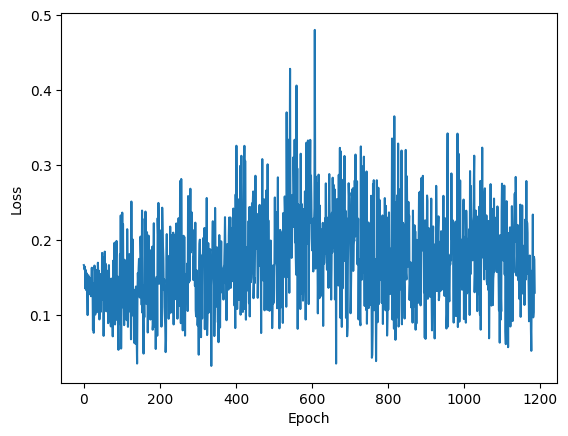

In [ ]:
plot_rewards(reward_history)
agent50.plot_loss()

###### Play a game (after training for 50 episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `ren

1/1 [==============================] - 0s 44ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 26ms/step
Episode: 1/5, Total Rewards: -3.4e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 24ms/step
Episode: 2/5, Total Rewards: -3.7e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more infor

1/1 [==============================] - 0s 27ms/step
Episode: 3/5, Total Rewards: -1.5e+01


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


1/1 [==============================] - 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 26ms/step
Episode: 4/5, Total Rewards: 2.1


/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CarRacing-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(


1/1 [==============================] - 0s 39ms/step


/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


1/1 [==============================] - 0s 29ms/step
Episode: 5/5, Total Rewards: 3.8e+01
Total Reward: 38.18181818181741


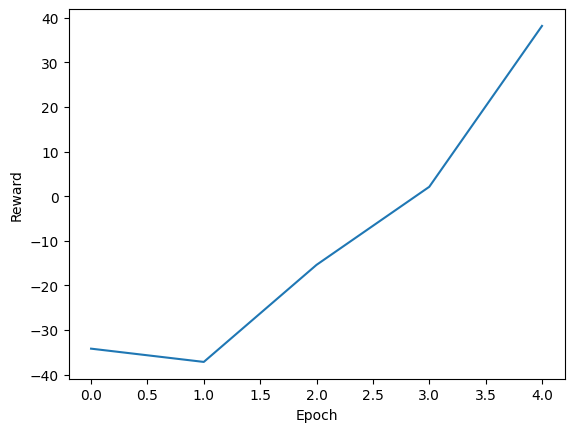

In [ ]:
reward_history = playGame(agent50, env, play_episodes=5, model_name=model_name)
plot_rewards(reward_history)

## Results

We evaluated the agent’s performance under varying training intensities(10, 30 and 50 training episodes) by analyzing the graphs of
gained reward and loss during training, as well as by assessing the
total reward achieved during gameplay. Additionally, we reviewed
example video replays of selected episodes to see agent behavior.
For the first two training intervals, no significant improvement is observed. The total reward remains low, and the loss
function shows instability. However, upon reviewing the episode
replays, early signs of learning become evident. After 10 episodes,
the agent begins to navigate closer to the inner edge of the track
during curves, though it struggles with maintaining control. After
30 episodes, the agent behaves slightly differently. While it leaves
the track, it is able to recover and find a way back.
By 50 episodes, more substantial improvements are evident. As
observed in the graphs, around 30 played episodes, there is a noticeable upward trend in the total reward, indicating that learning
is beginning to take place, and the loss function shows increased
stability. Replays further confirm that the agent follows the track
more closely and is able to recognize curves, though it occasionally
struggles to maintain position afterward. These results suggest that
the number of training episodes is a key factor in improving the
agent’s performance.

We can also check the total reward during game and during training in following table:

| ID    | Training episodes | Training reward | Game Reward
| -------- | ------- | -------- | ------- |
| 1  | 10   | 4.5  | -60.78431372549072|
| 2  | 30    | 4.7  | -77.77777777777757|
| 3  | 50    | 1.2e+01  | 38.18181818181741|


In contrast to the situation where the agent was trained on 10 and 30
episodes, for an agent trained on 50 episodes it can be observed
that the total game reward reached positive values and
is significantly higher.

# Conclusion

As a result of this project, the reinforcement learning agent was successfully trained for the 2D Box Car Racing environment. The learning process can be considered successful, as we observed positive trends in the agent's behavior with an increasing number of episodes. At the same time, the optimization library Optuna was used to tune the hyperparameters, which are crucial for reinforcement learning.

Training the agent for 50 episodes resulted in improvement. However,
the main limitation in achieving better results was the computational intensity, which restricted our ability to fully utilize hyperparameter optimization. This forced us to limit both the number of
agents and the parameter tuning range. Even with these constraints,
each run took several hours, and expanding the parameter range or
increasing the number of agents would require days of computation.
A similar issue arose with training duration, as running hundreds
of episodes with the current configuration would also take several
days. Despite these limitations, positive trends were observed in the
agent’s learning: reward values became positive, the reward graphs
showed upward progress, and the agent demonstrated improved
track handling.

#### Sources:
https://gymnasium.farama.org/environments/box2d/car_racing/

https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN

https://notanymike.github.io/Solving-CarRacing/

https://cnvrg.io/keras-custom-loss-functions/

https://optuna.org/